# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: November 2 (Thursday) 11:00 pm </font>  

<font color="blue"> Ben Poole </font>

# I. Overview
The goal of this assignment is to use Q-learning or SARSA to find a path through a 2D array to a goal node. The idea is to train an agent to successfully do this over time. The grid will be represented by a 2D array filled with Os, meaning moveable, and Hs, impassable. The letter G will represent the goal node or index the agent is trying to reach.

# II. Maze Problem
The problem here is that you must train an agent to navigate a maze. As previously stated the maze is represented by a 2d array with nodes filled with the letters O, H and G. Os represent possible locations to move to nd Hs represent impassable locations. The letter G will represent the location the agent is trying to reach. Overtime the agent should try different paths and learn from its mistake until it finally develops the best path to the goal node.

In [3]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [4]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

In [5]:
# maze example

debug = False
verbose = False


class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s
    
    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(s)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
            
    def get_actions(self):
        return self._actions

In [57]:
env = GridWorld("grid.txt")
print(env.get_size()[0] * env.get_size()[1])
print(env.get_actions())
env.print_map()

63
[[0, -1], [0, 1], [-1, 0], [1, 0]]
[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


# III. Methods


- greedy functions are here to determine if random actions should be taken or not during learning. 
- get_State encodes the position of the current state(location) into a singular number.
- get_goal_state returns the location of the goal node.


In [58]:
n_states = env.get_size()[0] * env.get_size()[1]
n_actions = len(env.get_actions())

def greedy(Q, s):
    return np.argmax(Q[s])  # greedy action selection

def e_greedy(Q, s, e):   
    if np.random.rand() < e:
        return np.random.randint(n_actions)
    else:
        return greedy(Q,s)
def get_State(s):
    return s[0] * env.get_size()[1] + s[1]

def get_goal_state():
        return [env.goal_pos[0][0],env.goal_pos[1][0]]
    

Q-Tables: For every episode the agent will run 200 steps, if not less, and try to find the best path to the goal node by calculating and looking at future reward potentials and actions. I have encoded the states into a singular value to ensure easier manipulation of the data. Throughout the code I will also track the number of steps, the episode reward total, the reward for states taken and trajectory. I decided to go with Qtables out of personal interest and the fact that it only looks at actions and cuts on computation time.

In [59]:
def qTable(alpha=1, gamma=.9, epsilon=.1):     
    Q = np.random.rand(n_states, n_actions)
    terminal_State = get_State(get_goal_state())
    eSum = np.zeros(100)
    steps = []
    contour = np.zeros(n_states) -100

    for e in range(100):
        env.init()
        s = env.get_cur_state()
        trace = [s]
        s = get_State(s)
        state = env.get_cur_state()
      
        for step in range(200):
            a = e_greedy(Q, s, epsilon)
            
            r1 = env.next(a)
            eSum[e] += r1
            
            s1 = env.get_cur_state()
            trace.append(s1)
            s1 = get_State(s1)

            if r1 > contour[s1]:
                contour[s1] = r1
            Q[s, a] += alpha * (r1 + gamma * np.max(Q[s1, :]) - Q[s, a])
            
            s = s1
            
            if s == terminal_State:
                break

        steps.append(step)
    #print("Final Q: ", Q)
    pi = np.argmax(Q, axis=1)
    print("Goal Location: ", get_goal_state())
    print("Policy:\n", np.reshape(pi, env.get_size()))
   
    return eSum, steps, contour, trace

In [60]:
eSum, steps, contour, trace = qTable(1, .9, .2)

Goal Location:  [5, 6]
Policy:
 [[1 1 3 3 3 3 1 1 3]
 [3 1 3 0 1 3 0 3 3]
 [1 1 1 3 0 2 1 3 3]
 [3 1 1 3 1 1 3 1 0]
 [3 3 2 1 1 1 3 0 3]
 [3 3 2 1 1 1 2 0 0]
 [1 1 1 1 1 1 2 2 2]]


# IV - Results

- Do to the limited scope on the project I had a difficult time accessing the optimal alpha, gamma, and epsilon values.

- Alpha: 1
- Gamma: .9
- Epsilon: .2

- I found that the most consistent and optimized alpha was around 1. I found that lowering the alpha would allow for more stepper changes in the episode sum and number of steps needed to be taken. I also noticed that as I approached .1 the trajectory would become more liberal with the states it visited. For my gamma I saw little to no effect from values ranging from .1 to .9. I believe this is because the limited number of steps and actions in this assignment. Never the less, I went with .9 because it seemed hold the best balance in number of steps and episode sum. Lastly for my epsilon I decided on was .2. I did notice there wasn’t any large effect on the trajectory until I got to an epsilon score of .5 or more. This is when I could visually see that the algorithm was taking random paths more than it needed to. 

Sum of Reqards Per Episode

[-124. -219.  -28. -142.   -6.  -24.  -18.   -1.   12.   -2.   -9.   -6.
   -3.   18.    0.  -17.   -8.   18.    5.   16.   14.   18.   20.   18.
    9.   15.   11.   18.   14.   15.   16.   10.   20.   16.   13.   13.
   20.   16.   16.    2.   18.   18.   18.   20.   18.   15.   20.    3.
   13.   20.   15.   18.   15.   20.   13.    1.   20.   13.    6.   20.
   20.   -7.   20.   15.   16.   18.   20.   14.   10.   16.   15.   11.
    8.   20.   20.   15.   10.   20.   -1.    6.   10.   15.   15.   18.
    8.   20.   20.   20.   20.   18.   20.   15.   10.   12.    9.   13.
   20.    8.   20.   15.]


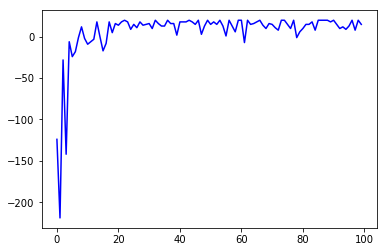

In [61]:
print(eSum)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(eSum, '-', color='b')

Number of Steps Per Episode

[82, 133, 42, 140, 28, 46, 48, 27, 18, 24, 27, 28, 21, 12, 30, 43, 30, 12, 21, 14, 16, 12, 10, 12, 17, 11, 15, 12, 16, 11, 14, 12, 10, 14, 13, 13, 10, 14, 14, 20, 12, 12, 12, 10, 12, 11, 10, 15, 13, 10, 11, 12, 11, 10, 13, 25, 10, 13, 16, 10, 10, 17, 10, 11, 14, 12, 10, 16, 12, 14, 11, 15, 14, 10, 10, 11, 12, 10, 19, 16, 12, 11, 11, 12, 14, 10, 10, 10, 10, 12, 10, 11, 12, 18, 17, 13, 10, 14, 10, 11]


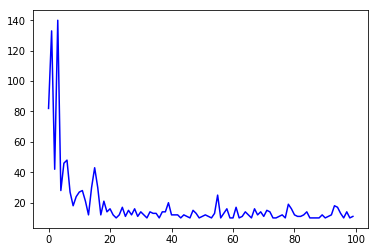

In [62]:
print(steps)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(steps, '-', color='b')

Contour Plot

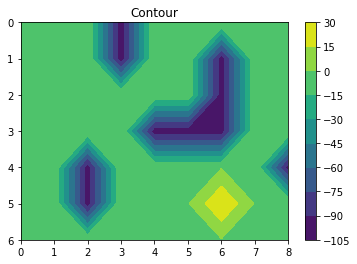

In [63]:
x,y = np.meshgrid(np.arange(env.get_size()[1]), np.arange(env.get_size()[0]))
s = get_State([y,x])
z = contour[s]
ax = fig.add_subplot(2,2,3)
plt.title("Contour")
plt.gca().invert_yaxis()
plt.contourf(x, y, z, 8)
plt.colorbar()

Trajectory of Solution

[array([0, 0]), array([0, 1]), array([0, 2]), array([1, 2]), array([2, 2]), array([2, 3]), array([3, 3]), array([4, 3]), array([4, 4]), array([4, 4]), array([4, 5]), array([4, 6]), array([5, 6])]


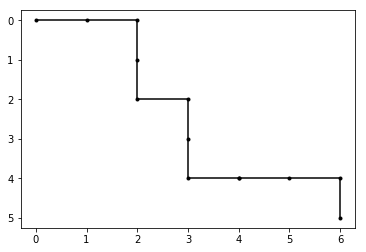

In [64]:
print(trace)
trace = np.array(trace)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.gca().invert_yaxis()
ax.plot(trace[:,1],trace[:,0], '-', color='k')
ax.plot(trace[:,1], trace[:,0], '.', color='k')

#  IV - Result Testing

High Epsilon

Goal Location:  [5, 6]
Policy:
 [[1 1 3 3 1 3 0 0 3]
 [1 1 3 2 3 3 1 1 3]
 [1 1 1 3 0 0 0 1 0]
 [1 1 1 3 3 0 0 3 0]
 [2 0 1 1 1 1 3 0 2]
 [1 3 0 1 1 1 3 0 0]
 [1 1 1 1 1 1 2 2 0]]


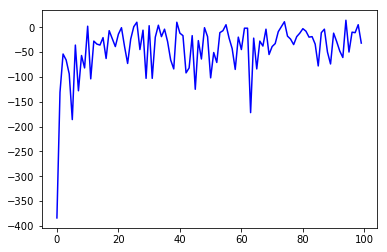

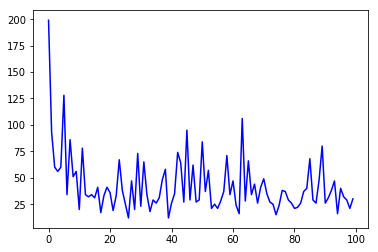

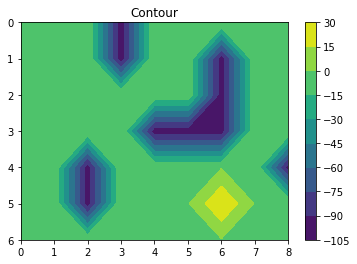

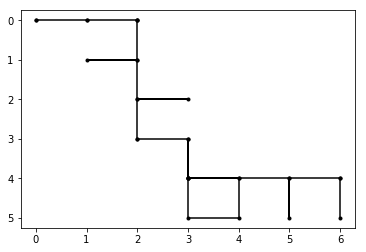

In [12]:
eSum, steps, contour, trace = qTable(1, .9, .7)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(eSum, '-', color='b')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(steps, '-', color='b')

fig = plt.figure()
x,y = np.meshgrid(np.arange(env.get_size()[1]), np.arange(env.get_size()[0]))
s = get_State([y,x])
z = contour[s]
ax = fig.add_subplot(1,1,1)
plt.title("Contour")
plt.gca().invert_yaxis()
plt.contourf(x, y, z, 8)
plt.colorbar()


trace = np.array(trace)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.gca().invert_yaxis()
ax.plot(trace[:,1],trace[:,0], '-', color='k')
ax.plot(trace[:,1], trace[:,0], '.', color='k')

Low Gamma

Goal Location:  [5, 6]
Policy:
 [[1 1 3 3 3 1 1 1 3]
 [1 3 3 1 2 0 3 1 0]
 [1 1 1 3 1 0 2 2 0]
 [3 1 1 3 0 1 2 3 0]
 [1 2 3 1 1 1 3 0 0]
 [2 2 0 1 1 1 1 0 1]
 [1 1 1 2 1 2 2 1 2]]


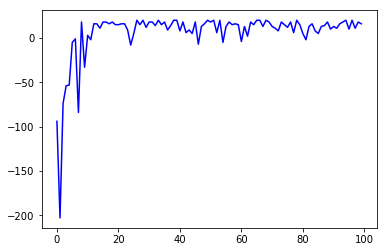

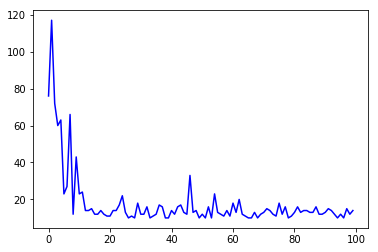

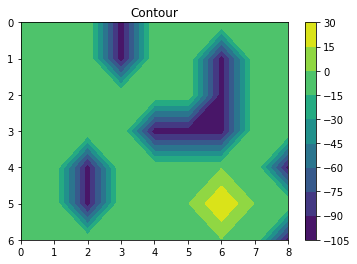

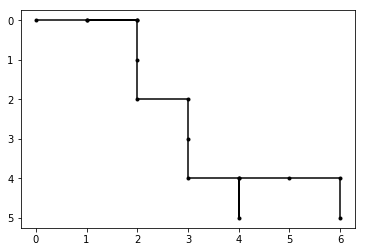

In [13]:
eSum, steps, contour, trace = qTable(1, .4, .2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(eSum, '-', color='b')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(steps, '-', color='b')

fig = plt.figure()
x,y = np.meshgrid(np.arange(env.get_size()[1]), np.arange(env.get_size()[0]))
s = get_State([y,x])
z = contour[s]
ax = fig.add_subplot(1,1,1)
plt.title("Contour")
plt.gca().invert_yaxis()
plt.contourf(x, y, z, 8)
plt.colorbar()



trace = np.array(trace)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.gca().invert_yaxis()
ax.plot(trace[:,1],trace[:,0], '-', color='k')
ax.plot(trace[:,1], trace[:,0], '.', color='k')

Low Alpha

Goal Location:  [5, 6]
Policy:
 [[3 3 0 3 3 0 0 3 1]
 [3 3 3 2 1 3 1 1 3]
 [1 1 1 3 0 2 3 1 3]
 [1 1 1 3 3 2 2 3 0]
 [1 2 0 1 1 1 3 0 3]
 [3 3 1 2 1 1 2 2 0]
 [1 1 1 2 2 1 2 3 3]]


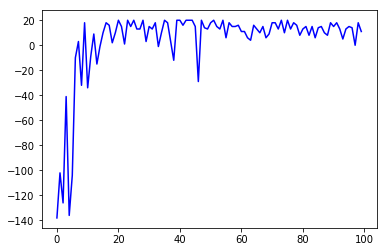

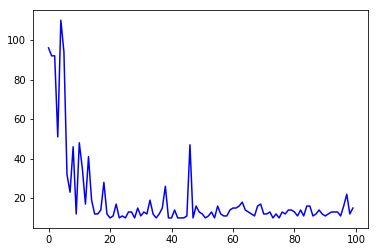

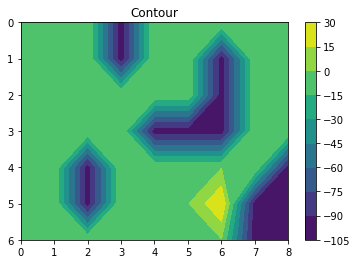

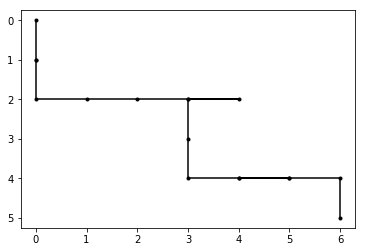

In [15]:
eSum, steps, contour, trace = qTable(.4, .9, .2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(eSum, '-', color='b')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(steps, '-', color='b')

fig = plt.figure()
x,y = np.meshgrid(np.arange(env.get_size()[1]), np.arange(env.get_size()[0]))
s = get_State([y,x])
z = contour[s]
ax = fig.add_subplot(1,1,1)
plt.title("Contour")
plt.gca().invert_yaxis()
plt.contourf(x, y, z, 8)
plt.colorbar()



trace = np.array(trace)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.gca().invert_yaxis()
ax.plot(trace[:,1],trace[:,0], '-', color='k')
ax.plot(trace[:,1], trace[:,0], '.', color='k')

# V. Conclusions
The only challenge I faced during this assignment was figuring out how to correctly graph the contour graph. I’m still not sure if I did it correctly but I got something that resembles the desired effect. If you know any good guides or examples that explain different matplotlib graphs it would be much appreciated. I find the documentation to be extremely lacking and hard to understand for a beginner. Overall, I am thoroughly surprised how easy Qtables yet interresting it was, in my mind I pictured something much more complicated.

# Extra Credit
Inverted Qtable

In [102]:
Inv_Zone = [[2,4], [3,2]]
Inv_Map = {0:1, 1:0, 2:3, 3:2}

def InvZone(s):
    return Inv_Zone[0][0] <= s[1] and Inv_Zone[0][1] >= s[0] and Inv_Zone[1][0] >= s[1] and Inv_Zone[1][1] <= s[0] 
def InvAction(a):
    return Inv_Map[a]

def InvQTable(alpha=1, gamma=.9, epsilon=.1):     
    Q = np.random.rand(n_states, n_actions)
    terminal_State = get_State(env.get_goal_state())
    eSum = np.zeros(100)
    steps = []
    contour = np.zeros(n_states) -100

    for e in range(100):
        env.init()
        loc_s = env.get_cur_state()
        trace = [loc_s]
        s = get_State(loc_s)
      
        for step in range(200):
            a = e_greedy(Q, s, epsilon)
            if InvZone(loc_s):
                a = InvAction(a)
            
            r1 = env.next(a)
            eSum[e] += r1
            
            loc_s = env.get_cur_state()
            trace.append(loc_s)
            s1 = get_State(loc_s)

            if r1 > contour[s1]:
                contour[s1] = r1
            Q[s, a] += alpha * (r1 + gamma * np.max(Q[s1, :]) - Q[s, a])
            
            s = s1
            
            if s == terminal_State:
                break

        steps.append(step)
    #print("Final Q: ", Q)
    pi = np.argmax(Q, axis=1)
    print("Goal Location", env.get_goal_state())
    print("Policy:\n", np.reshape(pi, env.get_size()))
   
    return eSum, steps, contour, trace

Goal Location [5, 6]
Policy:
 [[1 1 3 0 3 3 1 1 3]
 [1 1 3 2 3 0 2 3 2]
 [1 1 1 3 0 0 0 3 2]
 [1 1 1 3 2 2 3 3 0]
 [1 3 0 1 1 3 0 0 2]
 [1 3 3 1 1 1 3 0 2]
 [1 1 1 1 1 1 2 0 2]]


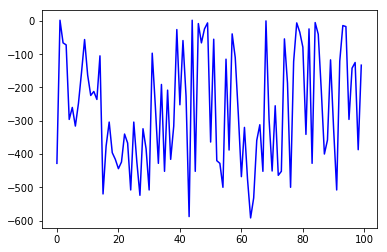

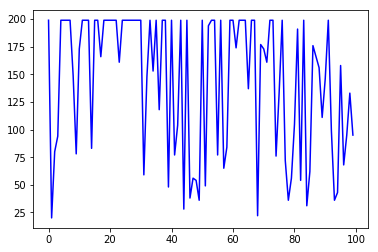

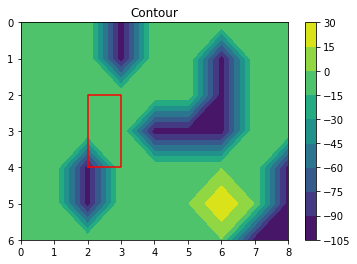

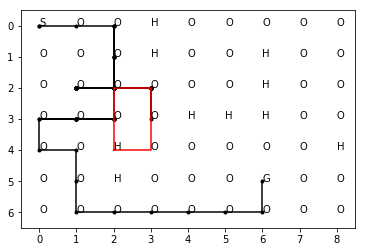

In [112]:
eSum, steps, contour, trace = InvQTable(1, .9, .2)
inv_plt_zone = np.array([[Inv_Zone[0][0],Inv_Zone[0][1]],
                   [Inv_Zone[1][0],Inv_Zone[0][1]],
                   [Inv_Zone[1][0],Inv_Zone[1][1]],
                   [Inv_Zone[0][0],Inv_Zone[1][1]],
                   [Inv_Zone[0][0],Inv_Zone[0][1]]])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(eSum, '-', color='b')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(steps, '-', color='b')

fig = plt.figure()
x,y = np.meshgrid(np.arange(env.get_size()[1]), np.arange(env.get_size()[0]))
s = get_State([y,x])
z = contour[s]
ax = fig.add_subplot(1,1,1)
plt.title("Contour")
plt.gca().invert_yaxis()
plt.contourf(x, y, z, 8)
plt.colorbar()
plt.plot(inv_plt_zone[:,0], inv_plt_zone[:,1], '-r')


trace = np.array(trace)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.gca().invert_yaxis()
ax.plot(trace[:,1],trace[:,0], '-', color='k')
ax.plot(trace[:,1], trace[:,0], '.', color='k')
ax.set_xlim([-.5,env.get_size()[1]-.5])
ax.set_ylim([env.get_size()[0]-.5,-.5])
plt.plot(inv_plt_zone[:,0], inv_plt_zone[:,1], '-r')
for x in range(env.get_size()[1]):
    for y in range(env.get_size()[0]):
        if x == 0 and y== 0:
             ax.text(x,y,'S')
        else:
            ax.text(x,y,env._map[y,x])

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
30 | Methods | 
 | 5| Choice of TD learning and Reason
 | 5| Description of the approach (either SARSA or Q-Learning)
 | 5| epsilon greedy codes and explanation
 |10| Implementation of the selected approach
 | 5| explanation of the codes
50 | Results 
| 5| Reports the selected parameters. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? 
|20| 5 points per each plot
| 5| reading and analysis of learning results and plots
5 | Conclusions 
